# IMPORTS

In [1]:
from google.colab import drive
drive.mount('/drive',force_remount=True)

Mounted at /drive


In [2]:
!unzip /drive/MyDrive/data.zip -d ../


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ../data/train/Slovenia_MB-ZG-900.jpg  
  inflating: ../data/train/Slovenia_MB-ZR-247.jpg  
  inflating: ../data/train/Slovenia_MS-AH-002.jpg  
  inflating: ../data/train/Slovenia_MS-AHM012.jpg  
  inflating: ../data/train/Slovenia_MS-BENO.jpg  
  inflating: ../data/train/Slovenia_MS-EURO.jpg  
  inflating: ../data/train/Slovenia_MS-FA-021.jpg  
  inflating: ../data/train/Slovenia_MS-FZ-420.jpg  
  inflating: ../data/train/Slovenia_MS-HI-489.jpg  
  inflating: ../data/train/Slovenia_MS-MURA.jpg  
  inflating: ../data/train/Slovenia_MS-VR-877.jpg  
  inflating: ../data/train/Slovenia_MS-VS-262.jpg  
  inflating: ../data/train/Slovenia_MS-VU-327.jpg  
  inflating: ../data/train/Slovenia_NM-AZ-913.jpg  
  inflating: ../data/train/Slovenia_NM-BG-734.jpg  
  inflating: ../data/train/Slovenia_NM-CL-737.jpg  
  inflating: ../data/train/Slovenia_NM-DB-665.jpg  
  inflating: ../data/train/Slovenia_NM-DZ-53

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
from os import path, listdir
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models, transforms
import torch.nn as nn
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, LSTM, Linear
from torch.optim import Adam
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch.nn.functional as F
import glob
import numpy as np
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 256
PLATE_SIZE = 12

# PreProcessing

In [6]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.1 MB/s eta 0:00:00


## Fonctions de preprocess

Dans cette étape, nous prétraitons les images, c'est-à-dire que nous extrayons les plaques d'immatriculation grâce aux détections (fichier detections.csv, qui contient les coordonnées des plaques extraites par le modèle YOLO). Ensuite, nous redimensionnons les plaques afin qu'elles aient toutes la même taille.

In [7]:
import os
import pandas as pd
import cv2
import torch
from unidecode import unidecode
from tqdm import tqdm
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor

def process_image(image_path, row, output_size):
    try:
        # Charger et découper l'image
        image = cv2.imread(image_path)
        if image is None:
            return None, None

        x_min, x_max, y_min, y_max = map(int, [row["X_min"], row["X_max"], row["Y_min"], row["Y_max"]])
        cropped = image[y_min:y_max, x_min:x_max]

        # Redimensionner avec transformations Torch
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(output_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x / 255.0 + 1e-3)
        ])

        processed_plate = transform(cropped)

        # Extraire et transformer l'étiquette
        plate = row["Plaque"]
        label = unidecode(plate).upper()

        return processed_plate, label
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

def extract_plates_and_labels(images_dir, csv_path, output_size):
    # Précharger les données du CSV
    detections = pd.read_csv(csv_path).set_index("Filename")

    plates, labels = [], []

    # Filtrer les fichiers image
    image_paths = [
        os.path.join(images_dir, img_name)
        for img_name in os.listdir(images_dir)
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    # Créer un dictionnaire des informations pour un accès plus rapide
    detections_dict = detections.to_dict(orient='index')

    def process_image_batch(image_path):
        img_name = os.path.basename(image_path)
        if img_name in detections_dict:
            row = detections_dict[img_name]
            return process_image(image_path, row, output_size)
        return None, None

    # Utiliser un ThreadPoolExecutor pour paralléliser le traitement des images
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_image_batch, image_paths), total=len(image_paths)))

    # Ajouter les résultats dans les listes
    for processed_plate, label in results:
        if processed_plate is not None and label is not None:
            plates.append(processed_plate)

            labels.append(label)

    return plates, labels


In [8]:
def encode_labels(labels, char_to_idx, padding_value=0, size=50):
    encoded_labels = [[char_to_idx[char] for char in label] for label in labels]

    # Pad each label to the max length
    for i in range(len(encoded_labels)):
        padding = [padding_value] * (size - len(encoded_labels[i]))
        encoded_labels[i].extend(padding)

    # Convert each list into a tensor
    tensor_labels = [torch.tensor(label, dtype=torch.long) for label in encoded_labels]

    return tensor_labels


# Dictionnaires pour encoder
char_to_idx = {
            '': 0,
            **{chr(i): idx for idx, i in enumerate(range(ord('A'), ord('Z') + 1), start=1)},
            **{str(i): idx + 26 for idx, i in enumerate(range(10))},
            '-': 37,
            ' ': 38,
            '.': 39
        }
idx_to_char = {v: k for k, v in char_to_idx.items()}

In [9]:
class PlateDataset(Dataset):
    def __init__(self, images,labels):

        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetch a single sample (image and label).

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, str]: The processed image tensor and its label.
        """
        return (self.images[idx],self.labels[idx])

In [10]:
csv_path = "/data/detections.csv"

X_train,Y_train = extract_plates_and_labels("/data/train",csv_path,(IMAGE_HEIGHT,IMAGE_WIDTH))
X_val,Y_val =  extract_plates_and_labels("/data/val",csv_path,(IMAGE_HEIGHT,IMAGE_WIDTH))
X_test,Y_test =  extract_plates_and_labels("/data/test",csv_path,(IMAGE_HEIGHT,IMAGE_WIDTH))

Y_train_encoded = encode_labels(Y_train,char_to_idx,0,PLATE_SIZE)
Y_val_encoded = encode_labels(Y_val,char_to_idx,0,PLATE_SIZE)
Y_test_encoded = encode_labels(Y_test,char_to_idx,0,PLATE_SIZE)



100%|██████████| 2927/2927 [00:35<00:00, 81.61it/s] 


In [11]:
print(f"NB train samples : {len(Y_train_encoded)}, X_train shape : {X_train[0].shape}")
print(f"NB val samples : {len(Y_val_encoded)}, X_val shape : {X_val[0].shape}")
print(f"NB test samples : {len(Y_test_encoded)}, X_test shape : {X_test[0].shape}")

NB train samples : 13294, X_train shape : torch.Size([3, 128, 256])
NB val samples : 2926, X_val shape : torch.Size([3, 128, 256])
NB test samples : 2927, X_test shape : torch.Size([3, 128, 256])


# Model

Model : actuellement un mobilenet pour extraire les features puis un transformer pour créer les séquences

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models

class CRNNWithLSTM(nn.Module):
    def __init__(self, num_classes, plate_size, image_height, image_width,
                 lstm_hidden_size=64, num_layers=2, dropout_rate=0.2):
        super(CRNNWithLSTM, self).__init__()
        self.plate_size = plate_size

        # Use MobileNetV3 as feature extractor
        mobilenet_v3 = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.features = mobilenet_v3.features  # Extract convolutional layers only

        OUTPUT_FEATURES = 960  # MobileNetV3 large outputs 960 channels in the last convolutional layer


        # 1x1 Conv to reduce channel dimensions if needed
        self.conv1x1 = nn.Conv2d(OUTPUT_FEATURES, 960, kernel_size=1)

        # Compute convolutional output size dynamically
        def calculate_conv_output_size(height, width):
            dummy_input = torch.zeros(1, 3, height, width)
            with torch.no_grad():
                output = self.features(dummy_input)
            return output.size(2), output.size(3)

        conv_h, conv_w = calculate_conv_output_size(image_height, image_width)
        self.feature_size = conv_h * conv_w * 960

        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.feature_size // plate_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_layers,
                            dropout=dropout_rate,
                            batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # Extract features with EfficientNet
        x = self.features(x)  # Shape: (batch_size, 1280, conv_h, conv_w)
        x = self.conv1x1(x)   # Shape: (batch_size, 1024, conv_h, conv_w)

        # Reshape and prepare for LSTM
        x = x.permute(0, 2, 3, 1).contiguous()  # Shape: (batch_size, conv_h, conv_w, 1024)
        x = x.view(batch_size, self.plate_size, -1)  # Shape: (batch_size, plate_size, feature_size // plate_size)

        # LSTM processing
        x, _ = self.lstm(x)  # Shape: (batch_size, plate_size, lstm_hidden_size)

        # Predict classes
        outputs = self.fc(x)  # Shape: (batch_size, plate_size, num_classes)
        return outputs


In [27]:
BATCH_SIZE = 16

# Créer le dataset et dataloader
dataset_train = PlateDataset(X_train,Y_train_encoded)
dataset_val = PlateDataset(X_val,Y_val_encoded)
dataset_test = PlateDataset(X_test,Y_test_encoded)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [36]:
model = CRNNWithLSTM(dropout_rate=0.3,num_classes=len(idx_to_char)+1,plate_size=PLATE_SIZE,image_height=IMAGE_HEIGHT,image_width=IMAGE_WIDTH)

In [37]:
import gc

gc.collect()



7137

# Train Model

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Move the model to the appropriate device
model = model.to(device)

EPOCHS = 100
PATIENCE = 5  # Stop if validation loss doesn't improve for 5 epochs
min_val_loss = float('inf')
patience_counter = 0
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    # Training loop
    for images, labels in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        images = images.to(device)
        labels = labels.to(device)  # Ensure labels are on the same device

        # Forward pass
        output = model(images)  # (batch_size, sequence_length, num_classes)
        output = output.permute(0, 2, 1)  # Change to (batch_size, num_classes, sequence_length)

        # Compute loss
        loss = criterion(output, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(dataloader_train)
    train_loss_values.append(epoch_train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader_val, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            output = output.permute(0, 2, 1)

            # Compute loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(dataloader_val)
    val_loss_values.append(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Early stopping logic
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"Validation loss improved. Model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered. Training stopped.")
        break

# Plot the loss graph for training and validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label="Training Loss")
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

print("Training complete. Best model saved as 'best_model.pth'.")


Using device: cuda


Epoch 1/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 69.76it/s]


Epoch [1/100], Train Loss: 2.3197, Validation Loss: 2.2735
Validation loss improved. Model saved.


Epoch 2/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 66.12it/s]


Epoch [2/100], Train Loss: 2.2674, Validation Loss: 2.2558
Validation loss improved. Model saved.


Epoch 3/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 84.70it/s]


Epoch [3/100], Train Loss: 2.2480, Validation Loss: 2.2262
Validation loss improved. Model saved.


Epoch 4/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 84.51it/s]


Epoch [4/100], Train Loss: 2.2382, Validation Loss: 2.2552
No improvement in validation loss. Patience: 1/5


Epoch 5/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 85.80it/s]


Epoch [5/100], Train Loss: 2.2314, Validation Loss: 2.2555
No improvement in validation loss. Patience: 2/5


Epoch 6/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 64.55it/s]


Epoch [6/100], Train Loss: 2.2246, Validation Loss: 2.2257
Validation loss improved. Model saved.


Epoch 7/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 67.80it/s]


Epoch [7/100], Train Loss: 2.2091, Validation Loss: 2.1948
Validation loss improved. Model saved.


Epoch 8/100 - Training:  80%|████████  | 668/831 [00:30<00:07, 23.23it/s]

# Evaluate Model

In [31]:
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()  # Mettre le modèle en mode évaluation.



CRNNWithLSTM(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), b

In [32]:
nbtot = 0
nb_good = 0

# Pour le calcul de l'accuracy par caractère
total_characters = 0
correct_characters = 0

sequence_accuracies = []
for images, labels in dataloader_test:
    # Obtenir les prédictions du modèle
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)  # Output shape: (batch_size, sequence_length, num_classes)
    predicted_labels = output.argmax(dim=2)  # Shape: (batch_size, sequence_length)

    # Comparer les prédictions avec les étiquettes de vérité terrain
    for i in range(len(predicted_labels)):
        predicted_text = "".join([idx_to_char[idx] for idx in predicted_labels[i].detach().cpu().numpy()])
        ground_truth = "".join([idx_to_char[idx] for idx in labels[i].detach().cpu().numpy()])

        # Calcul de l'accuracy globale (match exact)
        if ground_truth == predicted_text:
            nb_good += 1
        else :
            print(f"{ground_truth:^{40}} -- {predicted_text}")
        # Calcul de l'accuracy par caractère
        correct_characters += sum(1 for a, b in zip(predicted_text, ground_truth) if a == b)
        total_characters += len(ground_truth)

        nbtot += 1

# Calcul final des métriques
exact_match_accuracy = nb_good / nbtot if nbtot > 0 else 0
character_accuracy = correct_characters / total_characters if total_characters > 0 else 0

print(f'Exact Match Accuracy: {exact_match_accuracy:.2%}')
print(f'Character-level Accuracy: {character_accuracy:.2%}')
torch.save(model.state_dict(), f'model_MobileNet_lstm_char={character_accuracy:.2%}_word={exact_match_accuracy:.2%}.pth')  # Save the best model


                QD-4517                  -- OO-4577
               B-2008-Q0                 -- B-2008-O0
               02-020-ISI                -- 04-021-OET
                SK-301KT                 -- SK-301KK
                62A-063                  -- 82AJ063
               07-CE-5467                -- 07-CE-56677
               01-AR-939                 -- 01-AP-939
               SU-1482-AD                -- SV-1682-AD
                PN69VPA                  -- PN69VRA
                WD-4670P                 -- MD-4470Q
               A29-E-844                 -- A92-E-644
               WW-480-VW                 -- NW-480-NN
               CE-BP-627                 -- CE-BR-622
                GIH-577                  -- GIH-9717
               37-BA-527                 -- 37-BE-927
                FOY5J50                  -- FUY5J50
                51F-687                  -- 51F-5414
                HAD-376                  -- HAD-276
                O-34354               

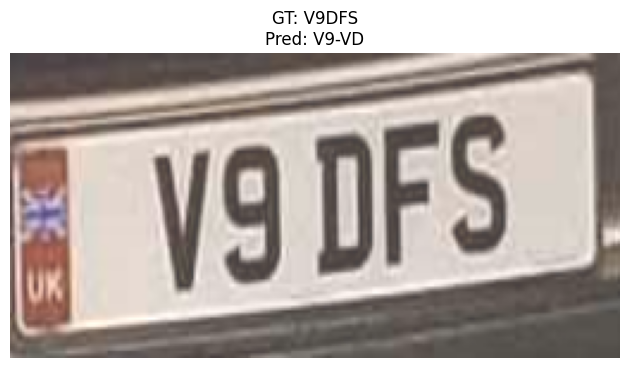

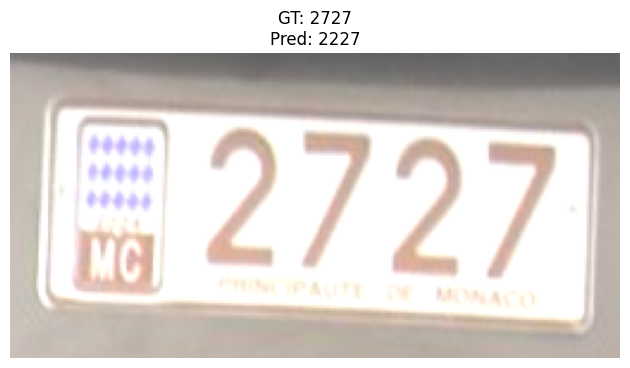

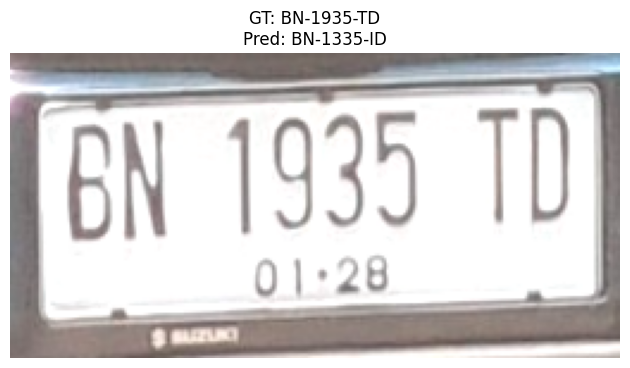

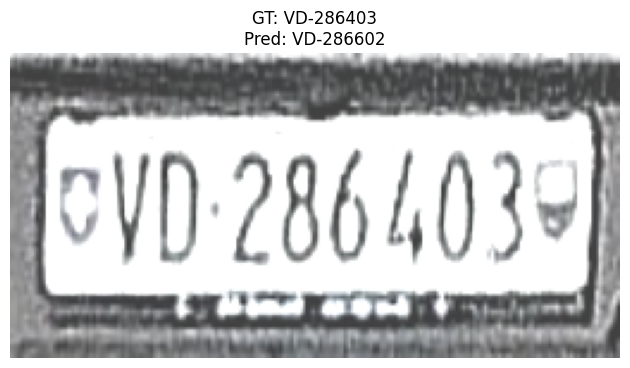

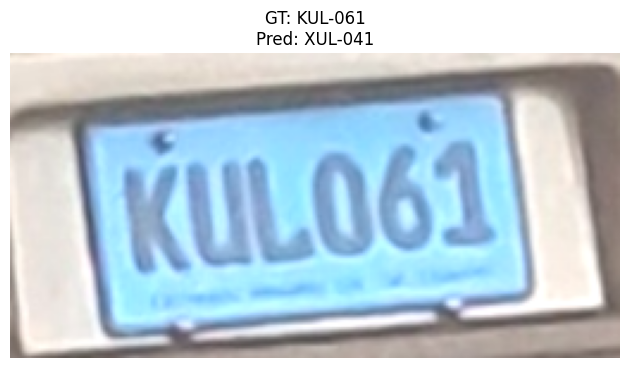

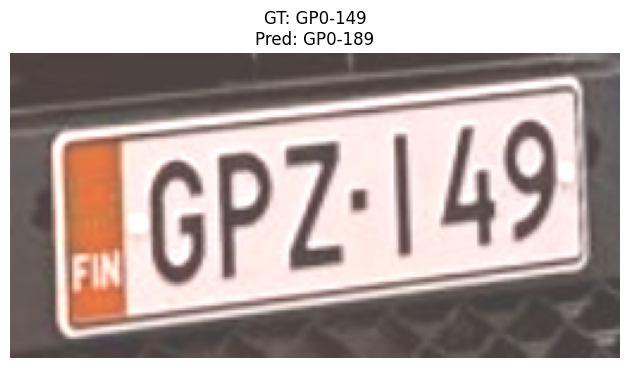

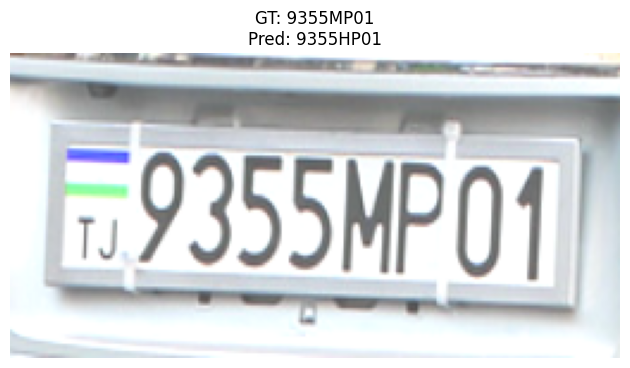

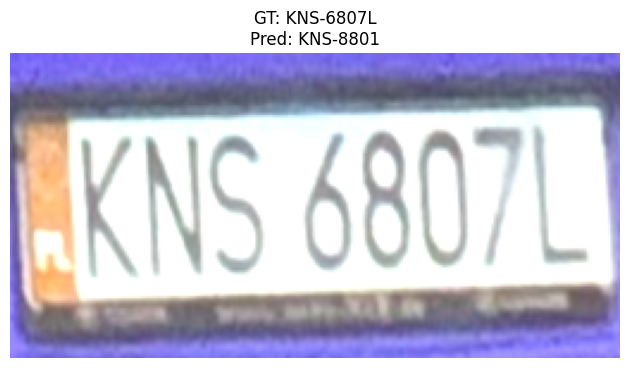

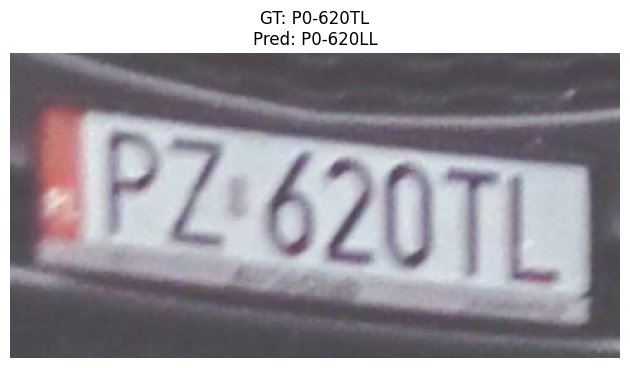

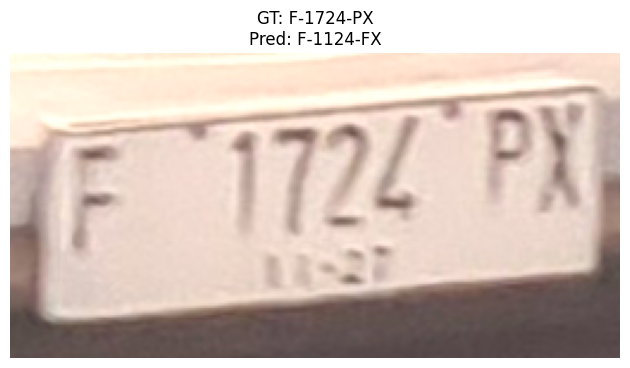

In [33]:

# Sélectionner aléatoirement 10 images
sampled_images = []
sampled_predictions = []
sampled_ground_truths = []

for images, labels in dataloader_test:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)  # Output shape: (batch_size, sequence_length, num_classes)
    predicted_labels = output.argmax(dim=2)  # Shape: (batch_size, sequence_length)

    for i in range(len(images)):
        if len(sampled_images) < 10:  # Collecter jusqu'à 10 échantillons
            sampled_images.append(images[i].detach().cpu())
            predicted_text = "".join([idx_to_char[idx] for idx in predicted_labels[i].detach().cpu().numpy()])
            ground_truth = "".join([idx_to_char[idx] for idx in labels[i].detach().cpu().numpy()])
            sampled_predictions.append(predicted_text)
            sampled_ground_truths.append(ground_truth)
        else:
            break
    if len(sampled_images) >= 10:
        break



for i,image in enumerate(sampled_images) :
    image = image.permute(1, 2, 0) *255 # Permuter pour obtenir (H, W, C)
    plt.imshow(image)
    plt.title(f"GT: {sampled_ground_truths[i]}\nPred: {sampled_predictions[i]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [34]:
from collections import Counter
letters = []

for label in Y_train :
    for char in label :
            letters.append(char)
# Compter les occurrences de chaque numéro
label_counts = Counter(letters)

# Afficher les résultats
for label, count in sorted(label_counts.items()):
    print(f"Caractère {label}: {count} occurrences")


Caractère -: 19503 occurrences
Caractère 0: 6698 occurrences
Caractère 1: 6016 occurrences
Caractère 2: 5227 occurrences
Caractère 3: 5010 occurrences
Caractère 4: 4652 occurrences
Caractère 5: 4660 occurrences
Caractère 6: 4774 occurrences
Caractère 7: 5109 occurrences
Caractère 8: 4555 occurrences
Caractère 9: 4885 occurrences
Caractère A: 3550 occurrences
Caractère B: 3089 occurrences
Caractère C: 1921 occurrences
Caractère D: 1659 occurrences
Caractère E: 1807 occurrences
Caractère F: 1308 occurrences
Caractère G: 1794 occurrences
Caractère H: 1610 occurrences
Caractère I: 1104 occurrences
Caractère J: 1132 occurrences
Caractère K: 2147 occurrences
Caractère L: 1607 occurrences
Caractère M: 1791 occurrences
Caractère N: 1558 occurrences
Caractère O: 944 occurrences
Caractère P: 1566 occurrences
Caractère Q: 320 occurrences
Caractère R: 1372 occurrences
Caractère S: 1718 occurrences
Caractère T: 1512 occurrences
Caractère U: 820 occurrences
Caractère V: 1472 occurrences
Caractère W: